In [1]:
import matplotlib.pyplot as plt
import xarray
import numpy as np
import datetime
import pandas as pd
from glob import glob

In [4]:
# Extract data
file_path = np.sort(glob('/Users/erickson/Documents/Data/RFROM/*.nc'))
full_data = xarray.open_mfdataset(file_path)

# Take average of 1x1 degree grid
lat = full_data['latitude'].values
lon = full_data['longitude'].values
time = full_data['time'].values
pressure = full_data['mean_pressure'].values

latind = np.argmin(np.abs(lat-40))
lonind = np.argmin(np.abs(lon-220))

#lat_indices = np.where((lat>=40) & (lat<=41))[0] # selecting out indices for 1˚x1˚ grid
#lon_indices = np.where((lon>=220) & (lon<=221))[0]

full_data_cropped = full_data.isel(latitude=latind, longitude=lonind)
#data = full_data[.mean(dim=['latitude','longitude'])

# Extract time and pressure values
#t = data['time'].values
#pressure = data['pressure'].values

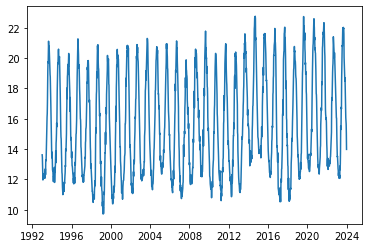

In [5]:
plt.plot(time,full_data['ocean_temperature'][:,0,latind,lonind])

In [24]:
# Implementing decimal year fxn found here: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years
# Input: array of np.datetime64 objects
# Output: same array converted into decimal year format, to be used for fitting models to a time series
def to_decimal_year(time):
    dt = pd.to_datetime(time) # converts np.datetime64 into datetime object
    dec_year = []
    for i in range(len(dt)):
        start = datetime.date(dt[i].year,1,1).toordinal()
        year_length = datetime.date(dt[i].year+1, 1, 1).toordinal() - start
        dec_year.append(dt[i].year + (float(dt[i].toordinal() - start) / year_length)) # calculates how much time has passed in the year, divides by year length, then adds to start year
    return np.array(dec_year)

# Remove trend from data by fitting a series of harmonics
# Input: array of times in np.datetime64 format, data array, number of harmonics (int), whether or not to remove trend (Boolean)
# Output: data array with mean, trend and/or seasonal cycle removed if specified
def detrend_data(t,data,num_harmonics=0, remove_trend=False):
    dyr = to_decimal_year(t) # convert from date-time to decimal year
    
    model = [np.ones(len(dyr)), dyr - np.mean(dyr)]
    for i in range(num_harmonics): # adding harmonics to model
        omega = 2*(i+1)*np.pi
        model.append(np.sin(omega*dyr))
        model.append(np.cos(omega*dyr))
    pmodel = np.linalg.pinv(np.array(model))
    
    # calculate coefficients / residuals (as specified by input)
    coefs = np.matmul(data, pmodel)
    mean = coefs[0]
    trend = coefs[1]*(dyr - np.mean(dyr))
    res_coefs = coefs[2:]
    
    seasons_model = [] # initialize model to be populated with code below
    
    if remove_trend == True: # case for removing both trend and seasonal cycle
        detrend_data = data-mean-trend
        for j in range(0,len(res_coefs),2):
            omega = (j+2)*np.pi
            detrend_data = detrend_data-(res_coefs[j]*np.sin(omega*dyr))-(res_coefs[j+1]*np.cos(omega*dyr)) 
            seasons_model.append(res_coefs[j]*np.sin(omega*dyr))
            seasons_model.append(res_coefs[j+1]*np.cos(omega*dyr))
            
    else: # case for leaving trend, removing seasonal cycle
        detrend_data = data-mean
        for j in range(0,len(res_coefs),2):
            omega = (j+2)*np.pi
            detrend_data = detrend_data-(res_coefs[j]*np.sin(omega*dyr))-(res_coefs[j+1]*np.cos(omega*dyr))
            seasons_model.append(res_coefs[j]*np.sin(omega*dyr))
            seasons_model.append(res_coefs[j+1]*np.cos(omega*dyr))
    
    seasons_model_final = np.sum(np.array(seasons_model), axis=0)
    
    results = {}
    results['data'] = detrend_data
    results['coefs'] = coefs
    results['trend'] = trend
    results['seasons_model'] = seasons_model_final
    
    return results

(-6.0, 8.0)

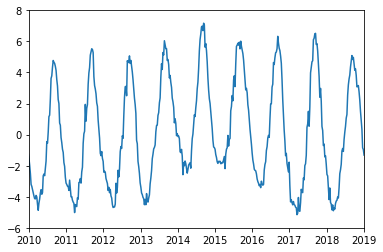

In [29]:
plt.plot(to_decimal_year(time),full_data['ocean_temperature'][:,0,latind,lonind]-np.mean(full_data['ocean_temperature'][:,0,latind,lonind]))
plt.xlim([2010,2019])
plt.ylim([-6,8])

In [39]:
# Testing functions with actual data
# from mhws_functions import to_decimal_year, detrend_data

surface_temp = np.array(full_data['ocean_temperature'][:,0,latind,lonind])

surface_temp_detrend = detrend_data(time, surface_temp, num_harmonics=0, remove_trend=True)
surface_temp_deseason_detrend = detrend_data(time, surface_temp, num_harmonics=6, remove_trend=True)

print("Coefficients, seasonal cycle included: ",surface_temp_detrend['coefs'])
print("Coefficients, seasonal cycle removed: ",surface_temp_deseason_detrend['coefs'])

Coefficients, seasonal cycle included:  [15.56729052  0.05555215]
Coefficients, seasonal cycle removed:  [ 1.55682305e+01  4.75036560e-02 -4.08075481e+00 -1.69110260e+00
  6.22429203e-01 -4.42416061e-01  2.36402699e-02  1.05122592e-01
 -1.72261776e-02 -5.10913813e-02  1.26952368e-02 -1.32261584e-02
  4.57446784e-03 -1.47502634e-02]


In [6]:
# Testing functions with actual data
# from mhws_functions import to_decimal_year, detrend_data

surface_temp = np.array(data['ocean_temperature'][:,0])
time = np.array(data['time'])

surface_temp_detrend = detrend_data(time, surface_temp, num_harmonics=0, remove_trend=True)
surface_temp_deseason_detrend = detrend_data(time, surface_temp, num_harmonics=6, remove_trend=True)

print("Coefficients, seasonal cycle included: ",surface_temp_detrend['coefs'])
print("Coefficients, seasonal cycle removed: ",surface_temp_deseason_detrend['coefs'])

Coefficients, seasonal cycle included:  [15.40512274  0.0578786 ]
Coefficients, seasonal cycle removed:  [ 1.54060298e+01  5.02191851e-02 -3.95290557e+00 -1.77288490e+00
  7.30942842e-01 -3.43275532e-01  2.61271069e-02  1.09622684e-01
 -1.02263579e-02 -2.79145223e-02  1.58938732e-02  4.95864176e-03
 -1.29302398e-02 -9.24926935e-04]


[-0.83314791 -0.83208253 -0.83101714 ...  0.83098147  0.83204686
  0.83311224]


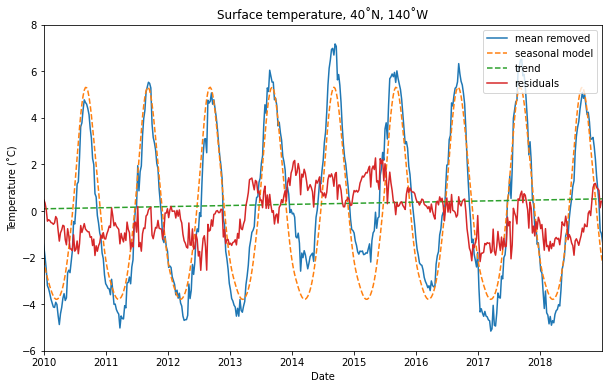

In [42]:
# Testing results by plotting
fig, ax=plt.subplots(figsize=(10, 6))
ax.plot(time, surface_temp - np.mean(surface_temp), label='mean removed')
ax.plot(time, surface_temp_deseason_detrend['seasons_model'], label='seasonal model', linestyle='--') # verifying seasons model is realistic-looking
#ax.plot(time, surface_temp_detrend['data'], label='no trend', linestyle='--')
ax.plot(time, surface_temp_deseason_detrend['trend'], label='trend', linestyle='--') # verifying trend != 0
ax.plot(time, surface_temp_deseason_detrend['data'], label='residuals')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (˚C)')
ax.set_title('Surface temperature, 40˚N, 140˚W')
ax.set_xlim([datetime.date(2010, 1, 1), datetime.date(2018, 12, 31)])
ax.legend(loc='upper right')
ax.plot()
ax.set_ylim([-6,8])
print((surface_temp-np.mean(surface_temp)) - surface_temp_detrend['data'])

[-0.86803896 -0.86692896 -0.86581896 ...  0.86578179  0.8668918
  0.8680018 ]


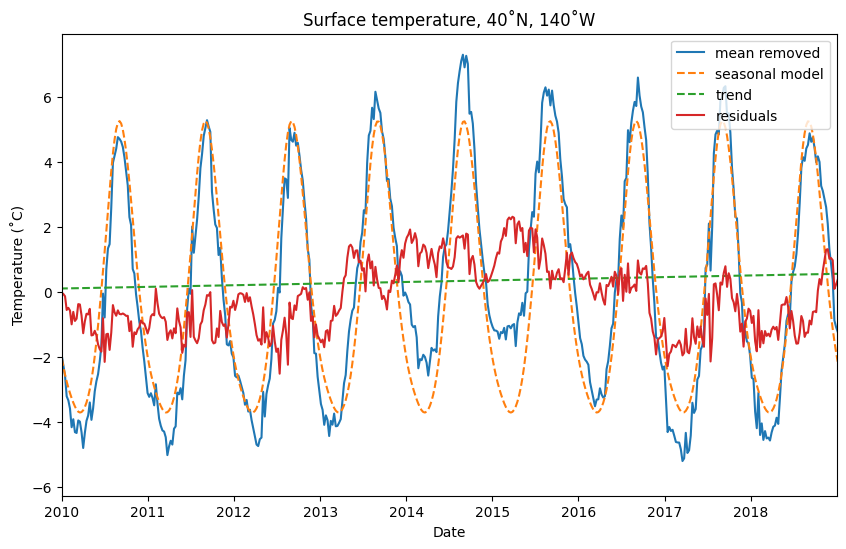

In [9]:
# Testing results by plotting
fig, ax=plt.subplots(figsize=(10, 6))
ax.plot(time, surface_temp - np.mean(surface_temp), label='mean removed')
ax.plot(time, surface_temp_deseason_detrend['seasons_model'], label='seasonal model', linestyle='--') # verifying seasons model is realistic-looking
#ax.plot(time, surface_temp_detrend['data'], label='no trend', linestyle='--')
ax.plot(time, surface_temp_deseason_detrend['trend'], label='trend', linestyle='--') # verifying trend != 0
ax.plot(time, surface_temp_deseason_detrend['data'], label='residuals')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (˚C)')
ax.set_title('Surface temperature, 40˚N, 140˚W')
ax.set_xlim([datetime.date(2010, 1, 1), datetime.date(2018, 12, 31)])
ax.legend(loc='upper right')
ax.plot()

print((surface_temp-np.mean(surface_temp)) - surface_temp_detrend['data'])

Coefficients:  [ 2.0e+01  1.0e-03  1.0e-01 -1.7e-04]


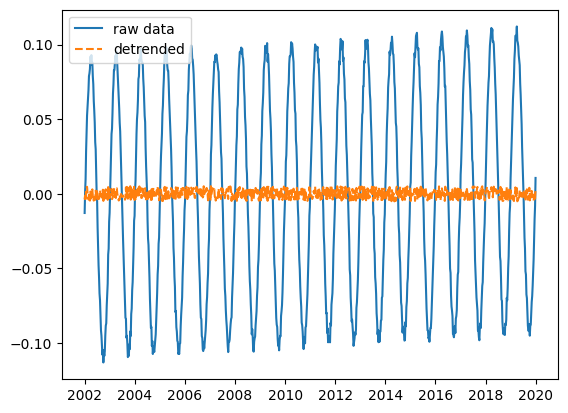

In [15]:
# Test on more simple time series
t = np.arange(np.datetime64('2002-01-01'),np.datetime64('2020-01-01'),7)
y = 20 + 0.001*(to_decimal_year(t)-2002) + 0.1*np.sin(2*np.pi*to_decimal_year(t))
y += np.random.rand(len(t))*.01
y_detrend=detrend_data(t,y,num_harmonics=1,remove_trend=True)

plt.plot(t,y-np.mean(y),label='raw data')
plt.plot(t,y_detrend['data'], label='detrended', linestyle='--')
plt.legend()

with np.printoptions(precision=2):
    print('Coefficients: ',np.array(y_detrend['coefs']))

Text(0, 0.5, 'Temperature (˚C)')

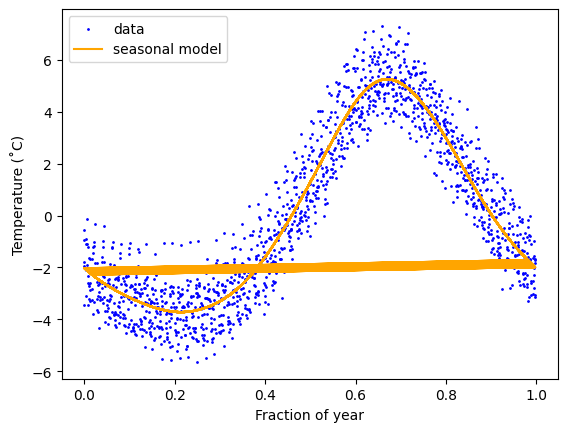

In [13]:
## Testing seasonal model by plotting against fraction of a year (0-1)

# Converting to fraction of a year
dyr = to_decimal_year(time)
fractional_year = [0] * len(dyr)
for i in range(len(dyr)):
    dt = pd.to_datetime(time[i])
    current_year = int(dt.year)
    fractional_year[i] = dyr[i] - current_year # subtract current year from decimal year date to get fraction
    
# Plotting results
fig,ax = plt.subplots()
ax.scatter(fractional_year, surface_temp - np.mean(surface_temp), label = 'data', c = 'blue', s=1)
ax.plot(fractional_year, surface_temp_deseason_detrend['seasons_model'], color='orange', label='seasonal model')
ax.legend()
ax.set_xlabel('Fraction of year')
ax.set_ylabel('Temperature (˚C)')